# CODE: *Anchors in the Machine: Behavioral and Attributional Evidence of Anchoring Bias in LLMs*
## GPT-2 — Minimal Replication

This notebook reproduces the experiment for **GPT-2 only** with:
- Log-probability scoring for numeric targets (`0..100%`)
- Exact Shapley values from log-probs over fields: `scene`, `anchor`, `comparative`, `absolute`

#### IMPORTANT NOTES ON OTHER MODELS

The loader function is written to support all six models used in the paper.
For simplicity, this notebook defaults to **GPT-2**, but you can switch `MODEL_NAME` to any of the following:

- `EleutherAI/gpt-neo-125M`
- `tiiuae/falcon-rw-1b`
- `microsoft/phi-2`
- `google/gemma-2b` *(gated; requires Hugging Face token)*
- `meta-llama/Llama-2-7b-hf` *(gated; requires Hugging Face token)*

#### Hardware & VRAM Guidance

- **Lightweight models** (GPT-2, GPT-Neo-125M) → run easily on CPU or modest GPUs (<1 GB VRAM).
- **Mid-size models** (Falcon-RW-1B, Phi-2, Gemma-2B) → need ~6–10 GB VRAM in FP16.
- **Large model** (LLaMA-2-7B) → requires ≥14–20 GB VRAM in FP16.

If your GPU does not meet these requirements:
- You can try **8-bit/4-bit quantization** (`BitsAndBytesConfig`, `device_map="auto"`) to fit large models on smaller GPUs.
- **Important:** Running with quantization or cloud-hosted inference may introduce **small numerical differences** in log-probabilities and Shapley values, so your replication may not be bit-for-bit identical.
- For full consistency with the reported results, match the local setup found in the step 1 and step 2.

#### Special Setup

- **Gated models (Gemma, LLaMA)** → request access on Hugging Face and set your token:
  ```bash
  export HUGGINGFACE_TOKEN=hf_xxxxxxxxxxxxx
    ```

### 1) Config & imports

In [155]:
import os
import time
from typing import Dict
from itertools import product

from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from jinja2 import Template
from scipy.stats import ttest_rel, wilcoxon
from scipy.special import logsumexp

# Experiment config
EXPERIMENT_NAME = "anchoring_gpt2"
# leaving MODEL_NAME = "gpt2" for the paper's demo.
MODEL_NAME = "gpt2"   # GPT-2 only
TARGET_TOKENS = [f"{i}%" for i in range(0, 101)]

def set_seed(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Optional quantization for LLaMA
try:
    from transformers import BitsAndBytesConfig
except Exception:
    BitsAndBytesConfig = None

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HF_TOKEN = os.getenv("HUGGINGFACE_TOKEN")  # needed for Gemma / LLaMA (gated)

# -----------------------------------------------
# Choose ONE model id (GPT-2 is the paper's demo)
# -----------------------------------------------
MODEL_NAME = "gpt2"

# Other models you used (uncomment one to run it):
# MODEL_NAME = "EleutherAI/gpt-neo-125M"      # small GPT-Neo
# MODEL_NAME = "google/gemma-2b"              # gated; needs HUGGINGFACE_TOKEN
# MODEL_NAME = "meta-llama/Llama-2-7b-hf"     # gated; use 8-bit w/ bitsandbytes
# MODEL_NAME = "microsoft/phi-2"              # 2.7B; fp16 + device_map="auto"
# MODEL_NAME = "tiiuae/falcon-rw-1b"          # 1B Falcon


print("DEVICE=", DEVICE)
print("MODEL_NAME=",MODEL_NAME)

DEVICE= cuda
MODEL_NAME= gpt2


### 2) Model load + teacher-forced log-prob

In [178]:
def load_model_and_tokenizer(model_name: str = MODEL_NAME):
    """
    Replicates the original loader logic for your six models.
    Notes on hardware:
      • GPT-2 / GPT-Neo-125M / Falcon-RW-1B run fine on CPU or modest GPUs.
      • Phi-2 (2.7B) benefits from GPU+fp16; will be slow on CPU.
      • LLaMA-2-7B + Gemma-2B are gated. Use cloud GPUs or 8/4-bit quantization;
        on weak hardware you may get CUDA OOM, long runtimes, or empty outputs.
    """
    name = model_name.lower()
    # 1) Gemma (gated)
    if "gemma" in name:
        if not HF_TOKEN:
            raise ValueError("Set HUGGINGFACE_TOKEN to use Google Gemma.")
        tok = AutoTokenizer.from_pretrained(model_name, use_auth_token=HF_TOKEN)
        model = AutoModelForCausalLM.from_pretrained(model_name, use_auth_token=HF_TOKEN)
        model.to(DEVICE)
    # 2) Meta LLaMA (quantized 8-bit w/ bitsandbytes)
    elif "meta-llama" in name or "llama-2" in name:
        if not HF_TOKEN:
            raise ValueError("Set HUGGINGFACE_TOKEN to use Meta LLaMA.")
        if BitsAndBytesConfig is None:
            raise ImportError("bitsandbytes is required. pip install bitsandbytes")
        bnb_cfg = BitsAndBytesConfig(
            load_in_8bit=True,                    # 8-bit quantization (fits on smaller GPUs)
            llm_int8_enable_fp32_cpu_offload=True
        )
        tok = AutoTokenizer.from_pretrained(model_name, use_fast=True, token=HF_TOKEN)
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            token=HF_TOKEN,
            quantization_config=bnb_cfg
        )
    # 3) Microsoft Phi-2
    elif "phi-2" in name:
        tok = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            torch_dtype=torch.float16  # fp16 recommended
        )
    # 4) Default (GPT-2, GPT-Neo-125M, Falcon-RW-1B)
    else:
        tok = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForCausalLM.from_pretrained(model_name)
        model.to(DEVICE)

    model.eval()
    return model, tok


# Exact scorer (unchanged): replicates your original runs
@torch.no_grad()
def get_sequence_logprob(model, tokenizer, prompt: str, target_text: str, device=None) -> float:
    """
    Replicates exactly:
      full_text = prompt + " " + target_text
      logits from model(full_text)
      sum log P(each target token | prefix up to previous token)
    """
    if device is None:
        device = next(model.parameters()).device

    full_text   = prompt + " " + target_text
    full_input  = tokenizer(full_text, return_tensors="pt").to(device)
    target_input= tokenizer(target_text, return_tensors="pt").to(device)

    outputs = model(**full_input)
    logits  = outputs.logits[0]

    # For some quantized pipelines (rare), logits may come back uint8
    if logits.dtype == torch.uint8:
        logits = logits.to(torch.float16)

    full_ids   = full_input["input_ids"][0]
    target_ids = target_input["input_ids"][0]
    start_idx  = len(full_ids) - len(target_ids)

    log_probs = F.log_softmax(logits, dim=-1)
    return sum(log_probs[start_idx + i - 1, tok].item() for i, tok in enumerate(target_ids))

model, tokenizer = load_model_and_tokenizer(MODEL_NAME)
print("Loaded:", MODEL_NAME, "on", DEVICE)

Loaded: gpt2 on cuda


### 3) Prompt templates & variations (four fields)

In [157]:
prompt_template = Template(
    "{{ scene }}{{ anchor }}.\n\n"
    "{{ comparative }}{{ anchor }}?\n\n"
    "{{ absolute }}"
)

def render_prompt(fields: Dict[str, str]) -> str:
    return prompt_template.render(**fields).strip()

def get_prompt_variations():
    # Anchors fixed at 10/65 (standard)
    return [
        {
            "fields": {
                "scene": "The roulette wheel landed on ",
                "comparative": "Is the percentage of African countries in the United Nations larger or smaller than ",
                "absolute": "What is your best guess of the percentage of African countries in the UN?"
            },
            "anchors": ["10", "65"]
        },
        {
            "fields": {
                "scene": "The spinner stopped at ",
                "comparative": "Do you think the percentage of Asian countries in the UN is higher or lower than ",
                "absolute": "Guess the percentage of Asian countries in the UN."
            },
            "anchors": ["10", "65"]
        },
        {
            "fields": {
                "scene": "You saw a wheel display ",
                "comparative": "Would you say the percentage of South American countries in the UN is more or less than ",
                "absolute": "Estimate the percentage of South American countries in the UN."
            },
            "anchors": ["10", "65"]
        },
        {
            "fields": {
                "scene": "The number you received was ",
                "comparative": "Is the share of English-speaking countries in the UN larger or smaller than ",
                "absolute": "Provide your best estimate of their percentage."
            },
            "anchors": ["10", "65"]
        },
        {
            "fields": {
                "scene": "The game spun a number: ",
                "comparative": "Is the proportion of EU member countries in the UN greater or lesser than ",
                "absolute": "What do you think is their percentage in the UN?"
            },
            "anchors": ["10", "65"]
        },
        {
            "fields": {
                "scene": "Imagine you just saw the number ",
                "comparative": "Would you say the percentage of French-speaking countries in the UN is above or below ",
                "absolute": "Estimate the percentage of French-speaking countries in the UN."
            },
            "anchors": ["10", "65"]
        }
    ]

def get_prompt_variations_different_anchors():
    # Different anchors per variation (10/65, 15/70, 20/75, ...)
    return [
        {
            "fields": {
                "scene": "The roulette wheel landed on ",
                "comparative": "Is the percentage of African countries in the United Nations larger or smaller than ",
                "absolute": "What is your best guess of the percentage of African countries in the UN?"
            },
            "anchors": ["10", "65"]
        },
        {
            "fields": {
                "scene": "The spinner stopped at ",
                "comparative": "Do you think the percentage of Asian countries in the UN is higher or lower than ",
                "absolute": "Guess the percentage of Asian countries in the UN."
            },
            "anchors": ["15", "70"]
        },
        {
            "fields": {
                "scene": "You saw a wheel display ",
                "comparative": "Would you say the percentage of South American countries in the UN is more or less than ",
                "absolute": "Estimate the percentage of South American countries in the UN."
            },
            "anchors": ["20", "75"]
        },
        {
            "fields": {
                "scene": "The number you received was ",
                "comparative": "Is the share of English-speaking countries in the UN larger or smaller than ",
                "absolute": "Provide your best estimate of their percentage."
            },
            "anchors": ["25", "80"]
        },
        {
            "fields": {
                "scene": "The game spun a number: ",
                "comparative": "Is the proportion of EU member countries in the UN greater or lesser than ",
                "absolute": "What do you think is their percentage in the UN?"
            },
            "anchors": ["30", "85"]
        },
        {
            "fields": {
                "scene": "Imagine you just saw the number ",
                "comparative": "Would you say the percentage of French-speaking countries in the UN is above or below ",
                "absolute": "Estimate the percentage of French-speaking countries in the UN."
            },
            "anchors": ["35", "90"]
        }
    ]

### 4) Exact Shapley over fields (in-memory)

In [158]:
FIELD_ORDER = ["scene", "comparative", "absolute", "anchor"]

NULL_FIELDS = {"scene": "", "anchor": "", "comparative": "", "absolute": ""}

def generate_field_permutations(fields: dict):
    keys = list(fields.keys())  # preserve insertion order exactly like your script
    combos = list(product([True, False], repeat=len(keys)))
    prompts = []
    for combo in combos:
        combo_fields = {k: (fields[k] if include else "") for include, k in zip(combo, keys)}
        prompts.append((combo, render_prompt(combo_fields)))
    return prompts, keys


def estimate_shapley(model, tokenizer, fields: Dict[str, str], target_token: str, device=None):
    if device is None:
        device = next(model.parameters()).device

    permutations, keys = generate_field_permutations(fields)
    logprobs = {combo: get_sequence_logprob(model, tokenizer, prompt, target_token, device=device)
                for combo, prompt in permutations}

    shapley = {}
    for i, field in enumerate(keys):
        contribs = []
        for combo in logprobs:
            if not combo[i]:
                with_combo = list(combo); with_combo[i] = True
                with_combo = tuple(with_combo)
                if with_combo in logprobs:
                    contribs.append(logprobs[with_combo] - logprobs[combo])
        shapley[field] = (sum(contribs) / len(contribs)) if contribs else 0.0
    
    return shapley

### 5) Experiment loop (returns a DataFrame)

In [159]:
def run_experiment(use_different_anchors: bool = False) -> pd.DataFrame:
    """
    Runs the replication and returns a DataFrame with:
      VariationID, Anchor, TargetToken, LogProbFullPrompt, Shapley_scene, Shapley_anchor, ...
      + TargetInt (0..100)
    No files are written; everything stays in-memory.
    """
    start = time.time()
    variations = (get_prompt_variations_different_anchors()
                  if use_different_anchors else
                  get_prompt_variations())

    rows = []
    total = len(variations) * len(TARGET_TOKENS) * 2  # 2 anchors per variation
    step = 0

    for variation_id, variation in enumerate(tqdm(variations, desc="Processing variations")):
        anchors = variation.get("anchors", [])
        fields_base = variation.get("fields", {})

        for anchor in anchors:
            fields = dict(fields_base)
            fields["anchor"] = anchor

            for target_token in TARGET_TOKENS:
                try:
                    prompt = render_prompt(fields)
                    logprob = get_sequence_logprob(model, tokenizer, prompt, target_token, device=DEVICE)
                    shapley_vals = estimate_shapley(model, tokenizer, fields, target_token, device=DEVICE)

                    row = {
                        "VariationID": variation_id,
                        "Anchor": anchor,
                        "TargetToken": target_token,
                        "LogProbFullPrompt": logprob,
                    }
                    for k, v in shapley_vals.items():
                        row[f"Shapley_{k}"] = v
                    rows.append(row)

                except Exception as e:
                    # Keep going; record the failure if desired
                    rows.append({
                        "VariationID": variation_id,
                        "Anchor": anchor,
                        "TargetToken": target_token,
                        "LogProbFullPrompt": np.nan,
                        "Shapley_scene": np.nan,
                        "Shapley_anchor": np.nan,
                        "Shapley_comparative": np.nan,
                        "Shapley_absolute": np.nan,
                        "Error": str(e)
                    })

                step += 1
                if step % 250 == 0 or step == total:
                    pass  # quiet log; add prints if you prefer

    df = pd.DataFrame(rows)
    if "TargetToken" in df.columns:
        df["TargetInt"] = pd.to_numeric(df["TargetToken"].str.replace("%", "", regex=False), errors="coerce")
    print(f"Completed in {time.time() - start:.2f}s; rows: {len(df)}")
    
    return df

### 7) Run Experiment for log-prob

In [160]:
# RUN: standard anchors
df_standard = run_experiment(use_different_anchors=False)

# Basic checks
print(df_standard.shape)
df_standard.tail(3)

Processing variations: 100%|██████████| 6/6 [04:00<00:00, 40.04s/it]

Completed in 240.23s; rows: 1212
(1212, 9)


,VariationID,Anchor,TargetToken,LogProbFullPrompt,Shapley_scene,Shapley_comparative,Shapley_absolute,Shapley_anchor,TargetInt
1209,5,65,98%,-14.232255,-0.704112,-0.822153,-0.674016,0.675189,98
1210,5,65,99%,-12.879784,-0.459722,-1.668666,-0.540445,0.429283,99
1211,5,65,100%,-12.257329,-0.820390,-1.152263,-0.908809,0.532300,100


In [161]:
# RUN: different anchors
df_different = run_experiment(use_different_anchors=True)

# Basic checks
print(df_different.shape)
df_different.tail(3)

Processing variations: 100%|██████████| 6/6 [04:12<00:00, 42.06s/it]

Completed in 252.35s; rows: 1212
(1212, 9)


,VariationID,Anchor,TargetToken,LogProbFullPrompt,Shapley_scene,Shapley_comparative,Shapley_absolute,Shapley_anchor,TargetInt
1209,5,90,98%,-14.216465,-0.939113,-0.673973,-0.459722,0.579434,98
1210,5,90,99%,-12.886213,-0.685309,-1.541192,-0.281544,0.378892,99
1211,5,90,100%,-12.074244,-1.040994,-1.029028,-0.712792,0.606636,100


### 8) Generate stats, tests, and metrics

In [162]:
# Tunables (defaults):
N_RESAMPLES = 5000      # bootstrap draws for EV bands
BOOT_SAMPLE_SIZE = 100  # samples per bootstrap draw (predictive band for mean of n generations)
N_PERMUTATIONS = 10000  # permutations for robustness permutation test
RANDOM_STATE = 42


def compute_soft_ev_bootstrap(sub_df, n_resamples=N_RESAMPLES, sample_size=BOOT_SAMPLE_SIZE, random_state=RANDOM_STATE):
    """
    Soft EV from normalized exp(logprob) and a predictive bootstrap CI,
    sampling from the implied categorical over targets.
    Returns: ev, ci_lower, ci_upper, std, samples
    """
    sub = sub_df[["LogProbFullPrompt", "TargetInt"]].dropna().copy()
    if sub.empty:
        return np.nan, np.nan, np.nan, np.nan, np.array([])

    L = sub["LogProbFullPrompt"].to_numpy(dtype=float)
    v = sub["TargetInt"].to_numpy(dtype=float)

    p = np.exp(L - logsumexp(L))
    ev = float(np.dot(v, p))

    rng = np.random.default_rng(random_state)
    m = len(v) if sample_size is None else int(sample_size)
    draws = rng.choice(v, size=(n_resamples, m), replace=True, p=p)
    samples = draws.mean(axis=1)

    lower = float(np.percentile(samples, 2.5))
    upper = float(np.percentile(samples, 97.5))
    std = float(np.std(samples, ddof=1))

    # Keep bounds within [0, 100]
    lower = max(0.0, lower)
    upper = min(100.0, upper)
    return ev, lower, upper, std, samples

def stars(p):
    if p is None or np.isnan(p): return ''
    if p < 0.01: return '***'
    if p < 0.05: return '**'
    if p < 0.10: return '*'
    return ''

def wilcoxon_two_sided(diffs):
    """
    Wilcoxon signed-rank on paired differences (two-sided).
    zero_method='pratt' to include zeros; if all zeros/NaNs, returns (nan, nan).
    """
    d = np.asarray(diffs, dtype=float)
    d = d[~np.isnan(d)]
    if d.size < 1 or np.allclose(d, 0):
        return np.nan, np.nan
    try:
        stat, p = wilcoxon(d, zero_method='pratt', alternative='two-sided', mode='auto')
        return float(stat), float(p)
    except ValueError:
        d_nz = d[~np.isclose(d, 0)]
        if d_nz.size < 1:
            return np.nan, np.nan
        stat, p = wilcoxon(d_nz, zero_method='wilcox', alternative='two-sided', mode='auto')
        return float(stat), float(p)

def permutation_pvalue_mean(diffs, n_perm=N_PERMUTATIONS, random_state=RANDOM_STATE):
    """
    Label-swap permutation test on paired differences (H0: sign equally likely).
    Statistic = mean(d). Returns two-sided p-value.
    """
    d = np.asarray(diffs, dtype=float)
    d = d[~np.isnan(d)]
    n = d.size
    if n == 0:
        return np.nan
    rng = np.random.default_rng(random_state)
    obs = float(np.mean(d))
    signs = rng.choice([-1.0, 1.0], size=(n_perm, n), replace=True)
    perm_means = (signs * d).mean(axis=1)
    p = (np.sum(np.abs(perm_means) >= abs(obs)) + 1.0) / (n_perm + 1.0)  # +1 correction
    return float(p)

### 9) Summarize results

In [163]:
def summarize_experiment(df: pd.DataFrame) -> pd.DataFrame:
    """
    Produces a per-Variation summary DataFrame in-memory.
    Expects columns: VariationID, Anchor, TargetInt, LogProbFullPrompt, Shapley_anchor.
    """
    summary_rows = []

    for vid in sorted(df["VariationID"].unique()):
        df_v = df[df["VariationID"] == vid]
        anchors = sorted(df_v["Anchor"].unique(), key=lambda x: int(x))
        if len(anchors) != 2:
            continue
        a1, a2 = anchors
        df1, df2 = df_v[df_v["Anchor"] == a1], df_v[df_v["Anchor"] == a2]

        # EV with bootstrap CI/std
        ev1, l1, u1, std1, _ = compute_soft_ev_bootstrap(df1)
        ev2, l2, u2, std2, _ = compute_soft_ev_bootstrap(df2)

        # Shapley means/stds
        shap_vals1 = df1["Shapley_anchor"].dropna().values
        shap_vals2 = df2["Shapley_anchor"].dropna().values
        shap_mean1 = np.mean(shap_vals1) if shap_vals1.size else np.nan
        shap_std1  = np.std(shap_vals1, ddof=1) if shap_vals1.size > 1 else np.nan
        shap_mean2 = np.mean(shap_vals2) if shap_vals2.size else np.nan
        shap_std2  = np.std(shap_vals2, ddof=1) if shap_vals2.size > 1 else np.nan

        # 95% CI for mean Shapley (normal approx)
        z = 1.96
        n1, n2 = shap_vals1.size, shap_vals2.size
        shap_ci1_lower = shap_mean1 - z * (shap_std1 / np.sqrt(n1)) if (n1 > 1 and not np.isnan(shap_std1)) else np.nan
        shap_ci1_upper = shap_mean1 + z * (shap_std1 / np.sqrt(n1)) if (n1 > 1 and not np.isnan(shap_std1)) else np.nan
        shap_ci2_lower = shap_mean2 - z * (shap_std2 / np.sqrt(n2)) if (n2 > 1 and not np.isnan(shap_std2)) else np.nan
        shap_ci2_upper = shap_mean2 + z * (shap_std2 / np.sqrt(n2)) if (n2 > 1 and not np.isnan(shap_std2)) else np.nan

        # Primary significance on LOGPROBS + robustness
        pivot_log = df_v.pivot(index="TargetInt", columns="Anchor", values="LogProbFullPrompt").dropna()
        if a1 in pivot_log.columns and a2 in pivot_log.columns and len(pivot_log) > 1:
            diffs = (pivot_log[a2] - pivot_log[a1]).to_numpy(dtype=float)
            t_log, p_log = ttest_rel(pivot_log[a1], pivot_log[a2])
            w_stat, p_wil = wilcoxon_two_sided(diffs)
            p_perm = permutation_pvalue_mean(diffs)
            log_mean1 = float(pivot_log[a1].mean())
            log_mean2 = float(pivot_log[a2].mean())
        else:
            t_log = p_log = w_stat = p_wil = p_perm = np.nan
            log_mean1 = log_mean2 = np.nan

        # Shapley paired t-test
        pivot_shap = df_v.pivot(index="TargetInt", columns="Anchor", values="Shapley_anchor").dropna()
        if a1 in pivot_shap.columns and a2 in pivot_shap.columns and len(pivot_shap) > 1:
            t_shap, p_shap = ttest_rel(pivot_shap[a1], pivot_shap[a2])
        else:
            t_shap, p_shap = np.nan, np.nan

        # Direction flags (behavioral via EV; attributional via Shapley means)
        TIE_EPS = 1e-12
        anchoring_ev   = int(ev2 > ev1) if (np.isfinite(ev1) and np.isfinite(ev2)) else np.nan
        anchoring_shap = int(shap_mean2 > shap_mean1) if (np.isfinite(shap_mean1) and np.isfinite(shap_mean2)) else np.nan
        shapley_bias   = int(shap_mean2 > 0) if np.isfinite(shap_mean2) else np.nan

        summary_rows.append({
            "VariationID": vid,
            "Anchor1": a1,
            "EV1": ev1, "EV1_std": std1, "CI1_lower": l1, "CI1_upper": u1,
            "Anchor2": a2,
            "EV2": ev2, "EV2_std": std2, "CI2_lower": l2, "CI2_upper": u2,

            "LogProbMean1": log_mean1, "LogProbMean2": log_mean2,
            "t_LogProb": t_log, "p_LogProb": p_log, "sig_LogProb": stars(p_log),

            "W_LogProb": w_stat, "p_Wilcoxon": p_wil, "sig_Wilcoxon": stars(p_wil),
            "p_Permutation": p_perm, "sig_Permutation": stars(p_perm),

            "ShapleyMean1": shap_mean1, "ShapleyStd1": shap_std1,
            "ShapleyCI1_lower": shap_ci1_lower, "ShapleyCI1_upper": shap_ci1_upper,
            "ShapleyMean2": shap_mean2, "ShapleyStd2": shap_std2,
            "ShapleyCI2_lower": shap_ci2_lower, "ShapleyCI2_upper": shap_ci2_upper,
            "t_ShapleyAnchor": t_shap, "p_ShapleyAnchor": p_shap, "sig_ShapleyAnchor": stars(p_shap),

            "Anchoring_EV": anchoring_ev,
            "Anchoring_ShapleyMean": anchoring_shap,
            "ShapleyBias": shapley_bias,

            # EV test placeholders (not used for stars here)
            "t_EV": np.nan, "p_EV": np.nan, "sig_EV": '',
        })

    return pd.DataFrame(summary_rows)

### 10) Inline plotting of SoftEV with bootstrap CI

In [164]:
def plot_softev_summary(summary_df: pd.DataFrame, title_note: str = ""):
    """
    Inline plot of SoftEV with bootstrap 95% predictive bands for each (Variation, Anchor),
    annotated with:
      - B-stars: paired t-test on logprobs
      - R: Wilcoxon (W) & Permutation (P) stars
      - A-stars: paired t-test on Shapley_anchor
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    x_labels, x_positions = [], []

    def safe_yerr(y, lo, hi):
        if not np.isfinite(y) or not np.isfinite(lo) or not np.isfinite(hi):
            return [[0.0], [0.0]]
        if hi < lo:
            lo, hi = hi, lo
        lower_len = max(0.0, float(y) - float(lo))
        upper_len = max(0.0, float(hi) - float(y))
        return [[lower_len], [upper_len]]

    TIE_EPS = 1e-12

    for _, row in summary_df.iterrows():
        a1 = int(row["Anchor1"])
        a2 = int(row["Anchor2"])

        default_colors = ["orange", "blue"] if a1 < a2 else ["blue", "orange"]
        colors = default_colors

        x1 = f"{int(row['VariationID'])}_{row['Anchor1']}"
        x2 = f"{int(row['VariationID'])}_{row['Anchor2']}"
        pos1 = len(x_positions)
        pos2 = pos1 + 1
        x_positions.extend([pos1, pos2])
        x_labels.extend([x1, x2])

        y1, y2 = float(row["EV1"]), float(row["EV2"])
        yerr1 = safe_yerr(y1, float(row["CI1_lower"]), float(row["CI1_upper"]))
        yerr2 = safe_yerr(y2, float(row["CI2_lower"]), float(row["CI2_upper"]))

        # Connectors
        ax.plot([pos1, pos2], [y1, y2], color="gray", linestyle="-", alpha=0.6, zorder=1)
        # Points + CI
        ax.errorbar(pos1, y1, yerr=yerr1, fmt='o', capsize=6, color=colors[0], zorder=2)
        ax.errorbar(pos2, y2, yerr=yerr2, fmt='o', capsize=6, color=colors[1], zorder=2)

        # Behavioral direction & stars from LOGPROB t-test (PRIMARY)
        if (np.isnan(y1) or np.isnan(y2)) or abs(y2 - y1) <= TIE_EPS:
            b_dir = "B0"
        else:
            b_dir = "B+" if y2 > y1 else "B–"
        b_text = f"{b_dir}{row['sig_LogProb']}"

        # Attributional direction & stars from Shapley paired t-test
        sm1, sm2 = row["ShapleyMean1"], row["ShapleyMean2"]
        if pd.isna(sm1) or pd.isna(sm2) or abs(sm2 - sm1) <= TIE_EPS:
            a_dir = "A0"
        else:
            a_dir = "A+" if sm2 > sm1 else "A–"
        a_text = f"{a_dir}{row['sig_ShapleyAnchor']}"

        # Robustness line: Wilcoxon + Permutation stars
        r_bits = []
        if isinstance(row['p_Wilcoxon'], (float, np.floating)) and not np.isnan(row['p_Wilcoxon']):
            r_bits.append(f"W{stars(row['p_Wilcoxon'])}")
        if isinstance(row['p_Permutation'], (float, np.floating)) and not np.isnan(row['p_Permutation']):
            r_bits.append(f"P{stars(row['p_Permutation'])}")
        r_text = "R: " + (" ".join(r_bits) if r_bits else "n/a")

        midpoint = (pos1 + pos2) / 2
        ax.annotate(
            f"{b_text}\n{a_text}\n{r_text}",
            xy=(midpoint, -0.33),
            xycoords=('data', 'axes fraction'),
            ha='center', va='top', fontsize=9
        )

    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_ylabel("Expected Value (%)")
    ax.set_xlabel("Variation_Anchor")
    title = "Soft Expected Value by Anchor — Bootstrap 95% Predictive Bands"
    if title_note:
        title += f" ({title_note})"
    ax.set_title(title + "\nB-stars: paired t-test on logprobs | R: Wilcoxon (W) & Permutation (P)")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_ylim(-8, 108)
    plt.subplots_adjust(bottom=0.35)
    plt.show()
    return fig, ax

### 11) Run stats, tests, and metrics

In [165]:
summary_standard  = summarize_experiment(df_standard)
summary_different = summarize_experiment(df_different)

display(summary_standard.tail(8))
display(summary_different.tail(8))

,VariationID,Anchor1,EV1,EV1_std,CI1_lower,CI1_upper,Anchor2,EV2,EV2_std,CI2_lower,...,ShapleyCI2_upper,t_ShapleyAnchor,p_ShapleyAnchor,sig_ShapleyAnchor,Anchoring_EV,Anchoring_ShapleyMean,ShapleyBias,t_EV,p_EV,sig_EV
0,0,10,39.732682,3.591570,32.55975,46.75000,65,44.604728,3.570160,37.48975,...,-0.126662,-6.319461,7.356027e-09,***,1,1,0,NaN,NaN,
1,1,10,40.177048,3.167824,33.85925,46.37000,65,52.667941,2.741675,47.06975,...,0.501253,-5.503520,2.878978e-07,***,1,1,1,NaN,NaN,
2,2,10,45.007294,3.301694,38.41950,51.43100,65,57.476039,2.836274,51.74975,...,0.662661,-4.098292,8.474250e-05,***,1,1,1,NaN,NaN,
3,3,10,44.727125,3.361483,37.99925,51.32025,65,56.673500,2.869306,50.82975,...,1.124943,-6.908492,4.620166e-10,***,1,1,1,NaN,NaN,
4,4,10,47.929921,3.230334,41.50000,54.25025,65,53.038820,3.097399,46.79975,...,0.005724,-9.000669,1.530915e-14,***,1,1,0,NaN,NaN,
5,5,10,37.502919,3.401248,30.74975,44.09025,65,50.850510,3.172439,44.50950,...,0.823398,-6.128469,1.769055e-08,***,1,1,1,NaN,NaN,


,VariationID,Anchor1,EV1,EV1_std,CI1_lower,CI1_upper,Anchor2,EV2,EV2_std,CI2_lower,...,ShapleyCI2_upper,t_ShapleyAnchor,p_ShapleyAnchor,sig_ShapleyAnchor,Anchoring_EV,Anchoring_ShapleyMean,ShapleyBias,t_EV,p_EV,sig_EV
0,0,10,39.732682,3.591570,32.55975,46.75000,65,44.604728,3.570160,37.48975,...,-0.126662,-6.319461,7.356027e-09,***,1,1,0,NaN,NaN,
1,1,15,39.524598,2.867227,33.76000,45.17025,70,52.364947,2.879635,46.50000,...,0.294350,0.853996,3.951481e-01,,1,0,1,NaN,NaN,
2,2,20,45.399850,2.995005,39.41000,51.33000,75,58.693416,2.891251,52.83975,...,0.625615,-3.606613,4.861193e-04,***,1,1,1,NaN,NaN,
3,3,25,47.230870,3.017978,41.20925,53.13025,80,55.687233,3.153513,49.34000,...,0.745713,4.534997,1.602883e-05,***,1,0,1,NaN,NaN,
4,4,30,48.873493,3.188334,42.50975,55.09025,85,52.428411,3.119700,46.18925,...,0.040234,-6.407713,4.886745e-09,***,1,1,0,NaN,NaN,
5,5,35,42.252437,2.983643,36.22950,48.15000,90,54.317522,3.531090,47.21975,...,0.478193,7.867663,4.371624e-12,***,1,0,1,NaN,NaN,


### 12) Plot SoftEV across variations

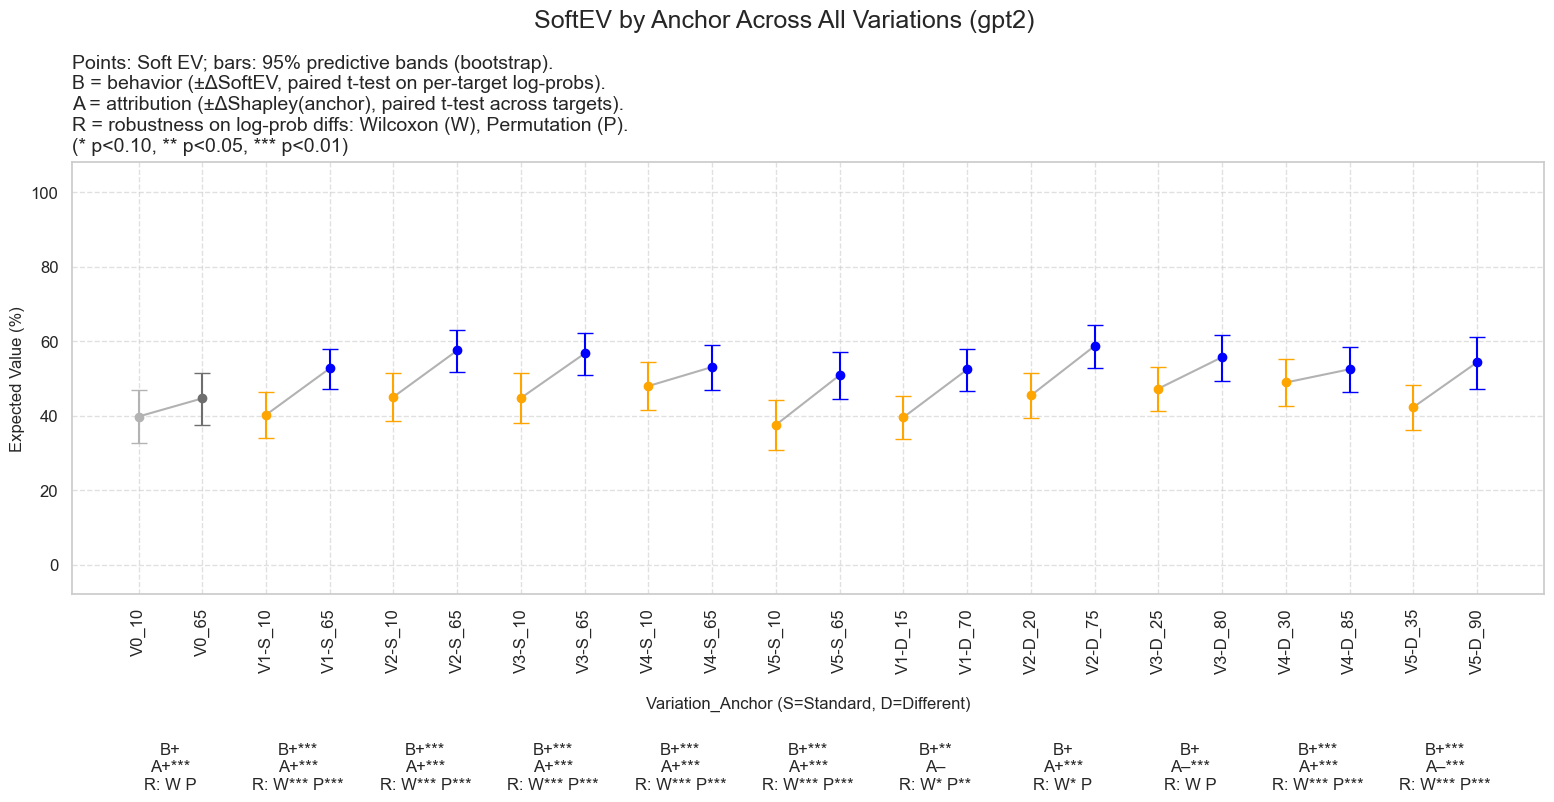

In [166]:
def combined_softev_plot_from_dfs(summary_standard: pd.DataFrame,
                                  summary_different: pd.DataFrame,
                                  model_name: str = "gpt2",
                                  save_path: str | None = None):
    # Input DFs (already computed by your in-notebook pipeline)
    df_std  = summary_standard.copy()
    df_diff = summary_different.copy()
    df_std["Suffix"]  = "standard"
    df_diff["Suffix"] = "different_anchors"

    # Ensure numeric VariationID and (string) anchors
    df_std["VariationID"]  = df_std["VariationID"].astype(int)
    df_diff["VariationID"] = df_diff["VariationID"].astype(int)
    df_std["Anchor1"] = df_std["Anchor1"].astype(str)
    df_std["Anchor2"] = df_std["Anchor2"].astype(str)
    df_diff["Anchor1"] = df_diff["Anchor1"].astype(str)
    df_diff["Anchor2"] = df_diff["Anchor2"].astype(str)

    # Build ordered combined DF: V0 once, then std V1..N, then diff V1..N
    parts = []
    v0_std  = df_std[df_std["VariationID"] == 0]
    v0_diff = df_diff[df_diff["VariationID"] == 0]
    if not v0_std.empty:
        parts.append(v0_std.iloc[[0]])
    elif not v0_diff.empty:
        parts.append(v0_diff.iloc[[0]])
    parts.append(df_std[df_std["VariationID"] != 0].sort_values("VariationID"))
    parts.append(df_diff[df_diff["VariationID"] != 0].sort_values("VariationID"))
    combo = pd.concat(parts, ignore_index=True)

    # Helpers (same as original)
    def stars(p):
        if p is None or (isinstance(p, float) and np.isnan(p)):
            return ''
        try:
            p = float(p)
        except Exception:
            return str(p)
        if p < 0.01: return '***'
        elif p < 0.05: return '**'
        elif p < 0.10: return '*'
        return ''

    def get_star(val):
        if val is None or (isinstance(val, float) and np.isnan(val)):
            return ''
        return str(val)

    def safe_yerr(y, lo, hi):
        if not np.isfinite(y) or not np.isfinite(lo) or not np.isfinite(hi):
            return [[0.0], [0.0]]
        if hi < lo:
            lo, hi = hi, lo
        lower_len = max(0.0, float(y) - float(lo))
        upper_len = max(0.0, float(hi) - float(y))
        return [[lower_len], [upper_len]]

    # Figure sizing: dynamic width based on number of groups
    n_groups = len(combo)
    base_width = 14
    scale_per_group = 1.0
    fig_width = max(base_width, base_width + scale_per_group * max(0, n_groups - 6))

    plt.figure(figsize=(fig_width, 9))
    x_labels, x_positions = [], []
    TIE_EPS = 1e-12
    sfx_tag = {"standard": "S", "different_anchors": "D"}

    for _, row in combo.iterrows():
        a1_int = int(row["Anchor1"]); a2_int = int(row["Anchor2"])
        default_colors = ["orange", "blue"] if a1_int < a2_int else ["blue", "orange"]
        is_base_variation = int(row["VariationID"]) == 0
        colors = ["#b3b3b3", "#6e6e6e"] if is_base_variation else default_colors

        vid = int(row["VariationID"])
        suffix = row.get("Suffix", "")
        tag = "" if vid == 0 else f"-{sfx_tag.get(suffix, '?')}"

        x1 = f"V{vid}{tag}_{row['Anchor1']}"
        x2 = f"V{vid}{tag}_{row['Anchor2']}"
        pos1 = len(x_positions); pos2 = pos1 + 1
        x_positions.extend([pos1, pos2]); x_labels.extend([x1, x2])

        y1 = float(row["EV1"]); y2 = float(row["EV2"])
        yerr1 = safe_yerr(y1, float(row["CI1_lower"]), float(row["CI1_upper"]))
        yerr2 = safe_yerr(y2, float(row["CI2_lower"]), float(row["CI2_upper"]))

        # Connect pair + points
        plt.plot([pos1, pos2], [y1, y2], color="gray", linestyle="-", alpha=0.6, zorder=1)
        plt.errorbar(pos1, y1, yerr=yerr1, fmt='o', capsize=6, color=colors[0], zorder=2)
        plt.errorbar(pos2, y2, yerr=yerr2, fmt='o', capsize=6, color=colors[1], zorder=2)

        # B: behavior (EV) + logprob stars
        if (not np.isfinite(y1)) or (not np.isfinite(y2)) or abs(y2 - y1) <= TIE_EPS:
            b_dir = "B0"
        else:
            b_dir = "B+" if y2 > y1 else "B–"
        b_text = f"{b_dir}{get_star(row.get('sig_LogProb', ''))}"

        # A: attribution (Shapley) + stars
        sm1, sm2 = row.get("ShapleyMean1", np.nan), row.get("ShapleyMean2", np.nan)
        if pd.isna(sm1) or pd.isna(sm2) or abs(float(sm2) - float(sm1)) <= TIE_EPS:
            a_dir = "A0"
        else:
            a_dir = "A+" if float(sm2) > float(sm1) else "A–"
        a_text = f"{a_dir}{get_star(row.get('sig_ShapleyAnchor', ''))}"

        # R: robustness stars
        r_bits = []
        p_wil  = row.get("p_Wilcoxon", np.nan)
        p_perm = row.get("p_Permutation", np.nan)
        if isinstance(p_wil, (float, np.floating)) and not np.isnan(p_wil):
            r_bits.append(f"W{stars(p_wil)}")
        if isinstance(p_perm, (float, np.floating)) and not np.isnan(p_perm):
            r_bits.append(f"P{stars(p_perm)}")
        r_text = "R: " + (" ".join(r_bits) if r_bits else "n/a")

        midpoint = (pos1 + pos2) / 2
        plt.annotate(f"{b_text}\n{a_text}\n{r_text}",
                     xy=(midpoint, -0.4),
                     xycoords=('data', 'axes fraction'),
                     ha='center', va='center', fontsize=12)

    # Axes & layout (same as original)
    plt.xticks(x_positions, x_labels, rotation=90, ha='center', fontsize=12)
    plt.yticks(fontsize=12)
    main_title = f"SoftEV by Anchor Across All Variations ({MODEL_NAME})"
    subtitle = (
        "Points: Soft EV; bars: 95% predictive bands (bootstrap).\n"
        "B = behavior (±ΔSoftEV, paired t-test on per-target log-probs).\n"
        "A = attribution (±ΔShapley(anchor), paired t-test across targets).\n"
        "R = robustness on log-prob diffs: Wilcoxon (W), Permutation (P).\n"
        "(* p<0.10, ** p<0.05, *** p<0.01)"
    )
    plt.suptitle(main_title, fontsize=18, y=1)
    plt.title(subtitle, fontsize=14, pad=8, loc="left")
    plt.ylabel("Expected Value (%)", fontsize=12)
    plt.xlabel("\nVariation_Anchor (S=Standard, D=Different)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.ylim(-8, 108)
    plt.subplots_adjust(bottom=0.35, top=0.83)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

    return combo

combo_df = combined_softev_plot_from_dfs(summary_standard, summary_different, model_name=MODEL_NAME)

### 13) Plot Shapley attribution

In [167]:
sns.set(style="whitegrid")

# helper: 2nd-order poly fit w/ bootstrap CI (same logic as your script)
def bootstrap_ci(x, y, degree=2, n_boot=5000, ci=95, rng=None):
    x = np.asarray(x); y = np.asarray(y)
    x_range = np.linspace(np.min(x), np.max(x), 200)
    if rng is None:
        rng = np.random.default_rng(42)
    preds = []
    n = len(x)
    for _ in range(n_boot):
        idx = rng.choice(n, n, replace=True)
        coeffs = np.polyfit(x[idx], y[idx], degree)
        preds.append(np.polyval(coeffs, x_range))
    preds = np.stack(preds, axis=0)
    lower = np.percentile(preds, (100 - ci) / 2, axis=0)
    upper = np.percentile(preds, 100 - (100 - ci) / 2, axis=0)
    mean  = preds.mean(axis=0)
    return x_range, mean, lower, upper

def plot_shapley_grid_for_df(df: pd.DataFrame,
                             suffix_text: str,
                             model_name: str = "gpt2",
                             save_path: str | None = None):
    """
    Build ONE combined figure (stacked rows per VariationID) using the given in-memory DF.
    Expects columns: VariationID, Anchor, Shapley_anchor, TargetInt (or TargetToken -> parsed to TargetInt).
    - V0 uses grey shades; others use orange/blue.
    - Left: Shapley vs TargetInt scatter + bootstrap trendline/CI (per anchor)
    - Right: boxplot + stripplot of Shapley by anchor
    If save_path is None -> show inline; else save to path.
    """
    df_plot = df.copy()
    # Ensure TargetInt exists
    if "TargetInt" not in df_plot.columns and "TargetToken" in df_plot.columns:
        df_plot["TargetInt"] = pd.to_numeric(df_plot["TargetToken"].str.replace("%", "", regex=False), errors="coerce")

    variations = sorted(df_plot["VariationID"].unique(), key=lambda v: (0 if int(v) == 0 else 1, int(v)))
    n_rows = len(variations)
    if n_rows == 0:
        raise ValueError("No variations found in DataFrame.")

    per_row_height = 3.2
    fig_width = 14
    fig_height = max(6, per_row_height * n_rows)
    fig, axes = plt.subplots(n_rows, 2, figsize=(fig_width, fig_height), squeeze=False)

    base_colors = ("#b3b3b3", "#6e6e6e")  # light/dark gray

    for r, variation_id in enumerate(variations):
        dvv = df_plot[df_plot["VariationID"] == variation_id].copy()
        anchors = sorted(dvv["Anchor"].astype(str).unique(), key=lambda x: int(x))
        is_base = int(variation_id) == 0

        if is_base:
            style_map = {
                anchors[0]: {"color": base_colors[0], "linestyle": "solid",  "marker": "o", "label": f"Anchor: {anchors[0]}"},
                anchors[1]: {"color": base_colors[1], "linestyle": "dashed", "marker": "s", "label": f"Anchor: {anchors[1]}"},
            }
        else:
            style_map = {
                anchors[0]: {"color": "orange", "linestyle": "solid",  "marker": "o", "label": f"Anchor: {anchors[0]}"},
                anchors[1]: {"color": "blue",   "linestyle": "dashed", "marker": "s", "label": f"Anchor: {anchors[1]}"},
            }

        ax_left  = axes[r, 0]
        ax_right = axes[r, 1]

        # LEFT: scatter + bootstrap polynomial trend + CI
        for a in anchors:
            sub = dvv[dvv["Anchor"].astype(str) == a]
            x = sub["TargetInt"].to_numpy()
            y = sub["Shapley_anchor"].to_numpy()

            ax_left.scatter(x, y, color=style_map[a]["color"],
                            marker=style_map[a]["marker"], alpha=0.6, s=40)

            if len(x) >= 3:  # need enough points for degree=2 fit
                xr, yp, lo, hi = bootstrap_ci(x, y, degree=2, n_boot=5000, ci=95)
                ax_left.plot(xr, yp, linestyle=style_map[a]["linestyle"],
                             color=style_map[a]["color"], label=style_map[a]["label"])
                ax_left.fill_between(xr, lo, hi, color=style_map[a]["color"], alpha=0.2)

        ax_left.set_title(f"V{variation_id}: Shapley vs Predicted Percentage (95% CI)")
        ax_left.set_xlabel("Predicted Percentage (%)")
        ax_left.set_ylabel("Shapley Value")
        ax_left.grid(True, linestyle="--", alpha=0.6)

        # RIGHT: boxplot + stripplot
        sns.boxplot(
            data=dvv, x="Anchor", y="Shapley_anchor", hue="Anchor",
            palette=[style_map[a]["color"] for a in anchors],
            showfliers=False, width=0.5, boxprops=dict(alpha=0.6),
            legend=False, ax=ax_right
        )
        for a in anchors:
            sns.stripplot(
                data=dvv[dvv["Anchor"].astype(str) == a],
                x="Anchor", y="Shapley_anchor",
                color=style_map[a]["color"], size=5,
                marker=style_map[a]["marker"], edgecolor="grey", linewidth=0.4,
                alpha=0.7, jitter=True, ax=ax_right
            )
        ax_right.set_title(f"V{variation_id}: Shapley Boxplot")
        ax_right.set_xlabel("Anchor in Prompt")
        ax_right.set_ylabel("Shapley Value")
        ax_right.grid(True, linestyle="--", alpha=0.6)

    # Figure-level legend (outside, centered)
    handles = [
        Line2D([0], [0], color="orange", marker="o", linestyle="solid",  label="Anchor A"),
        Line2D([0], [0], color="blue",   marker="s", linestyle="dashed", label="Anchor B"),
    ]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 0.938),
               ncol=2, frameon=True)

    fig.suptitle(f"All Shapley Values for '{suffix_text}' Variations ({MODEL_NAME})",
                 y=0.95, fontsize=14)
    plt.subplots_adjust(top=0.90, hspace=0.5, wspace=0.25)

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

    return fig, axes

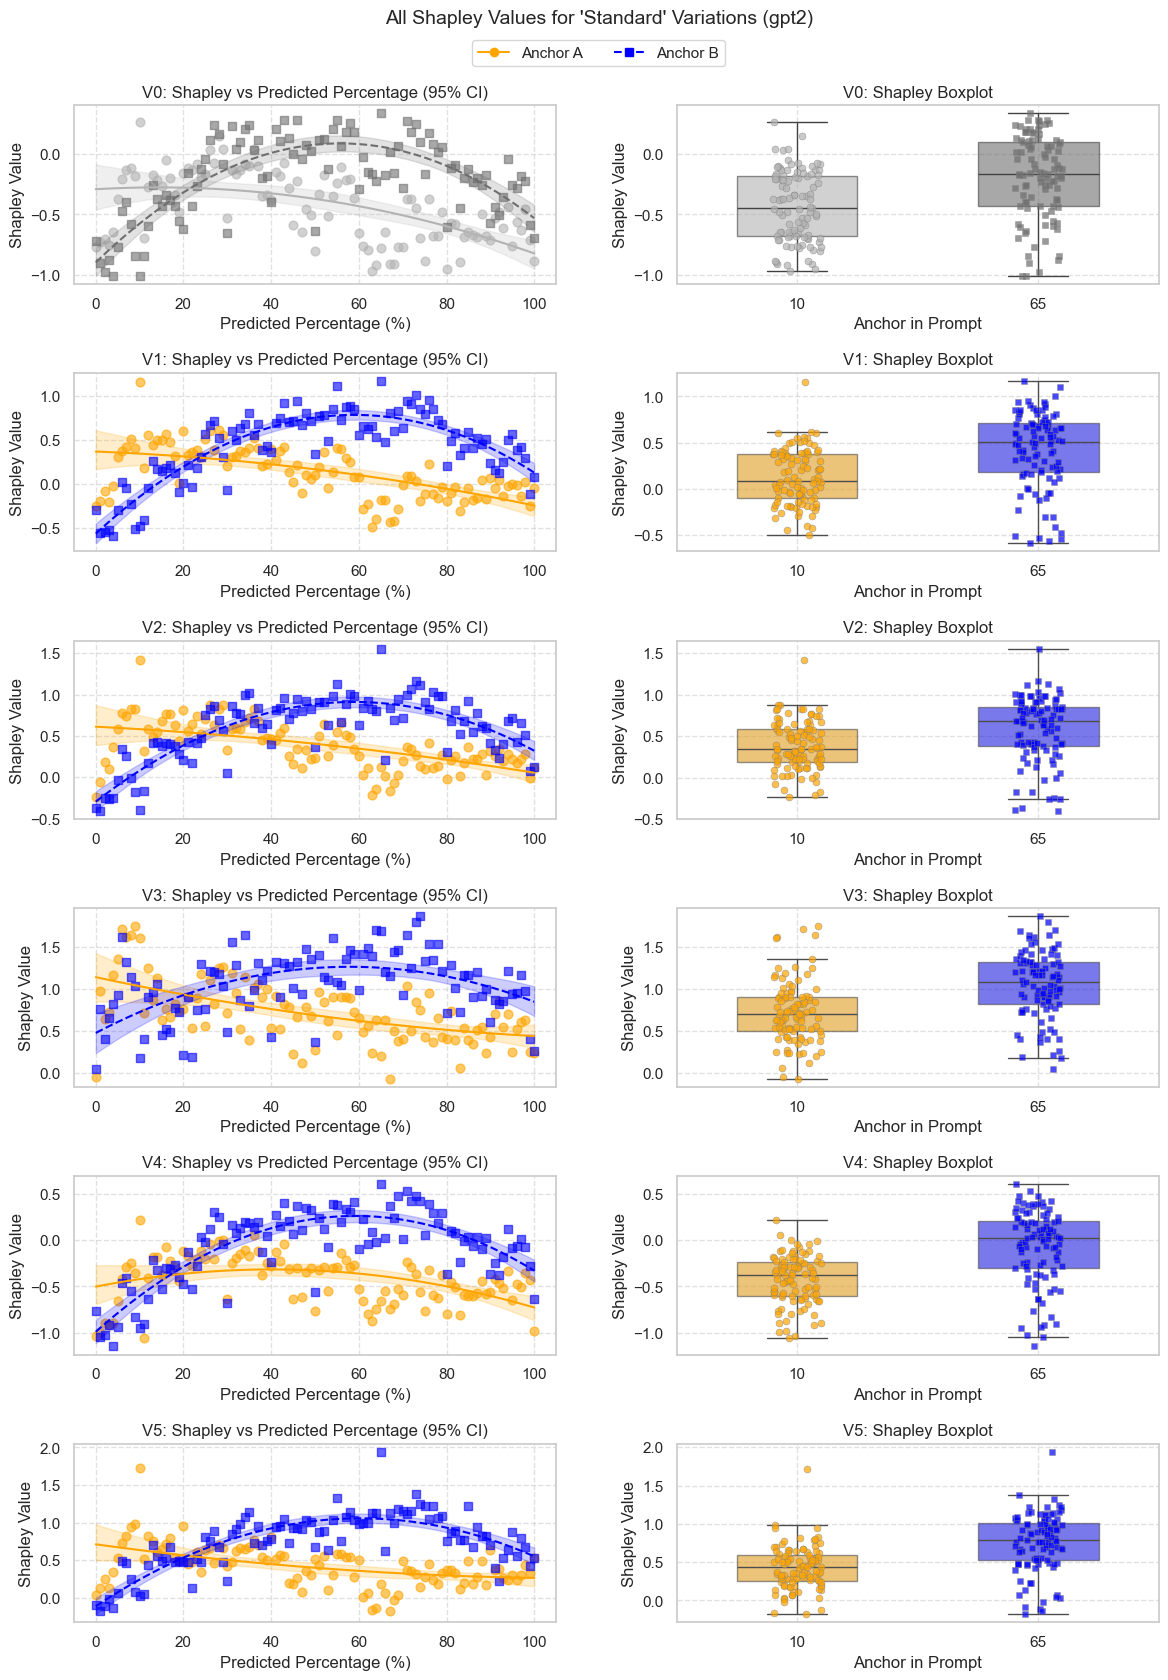

(<Figure size 1400x1920 with 12 Axes>,
 array([[<Axes: title={'center': 'V0: Shapley vs Predicted Percentage (95% CI)'}, xlabel='Predicted Percentage (%)', ylabel='Shapley Value'>,
         <Axes: title={'center': 'V0: Shapley Boxplot'}, xlabel='Anchor in Prompt', ylabel='Shapley Value'>],
        [<Axes: title={'center': 'V1: Shapley vs Predicted Percentage (95% CI)'}, xlabel='Predicted Percentage (%)', ylabel='Shapley Value'>,
         <Axes: title={'center': 'V1: Shapley Boxplot'}, xlabel='Anchor in Prompt', ylabel='Shapley Value'>],
        [<Axes: title={'center': 'V2: Shapley vs Predicted Percentage (95% CI)'}, xlabel='Predicted Percentage (%)', ylabel='Shapley Value'>,
         <Axes: title={'center': 'V2: Shapley Boxplot'}, xlabel='Anchor in Prompt', ylabel='Shapley Value'>],
        [<Axes: title={'center': 'V3: Shapley vs Predicted Percentage (95% CI)'}, xlabel='Predicted Percentage (%)', ylabel='Shapley Value'>,
         <Axes: title={'center': 'V3: Shapley Boxplot'}, xlabel

In [168]:
# Usage: ONE plot for standard, ONE for different
plot_shapley_grid_for_df(df_standard,  suffix_text="Standard",  model_name=MODEL_NAME)

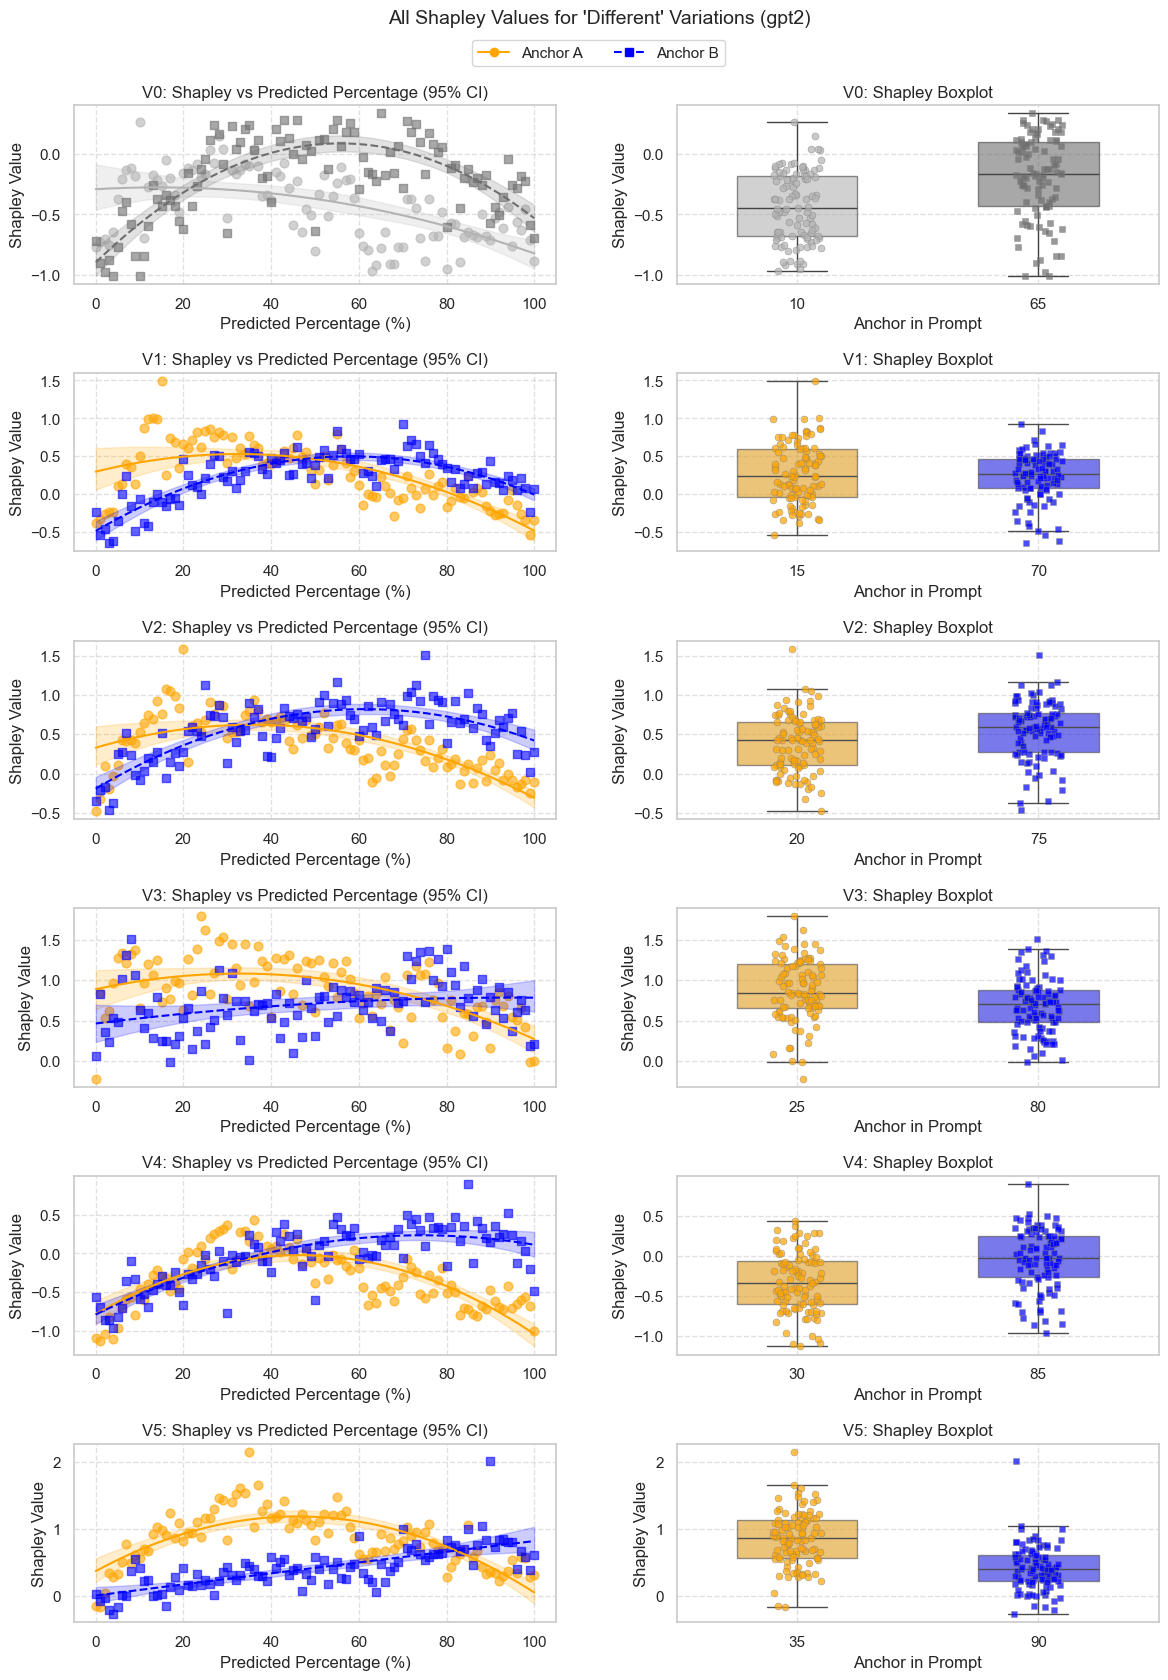

(<Figure size 1400x1920 with 12 Axes>,
 array([[<Axes: title={'center': 'V0: Shapley vs Predicted Percentage (95% CI)'}, xlabel='Predicted Percentage (%)', ylabel='Shapley Value'>,
         <Axes: title={'center': 'V0: Shapley Boxplot'}, xlabel='Anchor in Prompt', ylabel='Shapley Value'>],
        [<Axes: title={'center': 'V1: Shapley vs Predicted Percentage (95% CI)'}, xlabel='Predicted Percentage (%)', ylabel='Shapley Value'>,
         <Axes: title={'center': 'V1: Shapley Boxplot'}, xlabel='Anchor in Prompt', ylabel='Shapley Value'>],
        [<Axes: title={'center': 'V2: Shapley vs Predicted Percentage (95% CI)'}, xlabel='Predicted Percentage (%)', ylabel='Shapley Value'>,
         <Axes: title={'center': 'V2: Shapley Boxplot'}, xlabel='Anchor in Prompt', ylabel='Shapley Value'>],
        [<Axes: title={'center': 'V3: Shapley vs Predicted Percentage (95% CI)'}, xlabel='Predicted Percentage (%)', ylabel='Shapley Value'>,
         <Axes: title={'center': 'V3: Shapley Boxplot'}, xlabel

In [169]:
# Usage: ONE plot for standard, ONE for different
plot_shapley_grid_for_df(df_different, suffix_text="Different", model_name=MODEL_NAME)

### 14) Anchoring Bias Sensitivity Score:

In [170]:
# utilities
def signed(x: float, eps: float = 1e-12) -> int:
    if not np.isfinite(x) or abs(x) < eps:
        return 0
    return 1 if x > 0 else -1

def tanh_abs(x: float) -> float:
    if not np.isfinite(x):
        return 0.0
    return float(np.tanh(abs(x)))

def p_to_weight(p: float, mode: str = "log") -> float:
    if not np.isfinite(p) or p <= 0:
        return 0.0
    if mode == "log":
        w = -np.log10(p) / 3.0
        return float(np.clip(w, 0.0, 1.0))
    elif mode == "thresh":
        if p < 0.01: return 1.0
        if p < 0.05: return 0.7
        if p < 0.10: return 0.4
        return 0.0
    w = -np.log10(p) / 3.0
    return float(np.clip(w, 0.0, 1.0))

def robustness_scale(p_wil, p_perm, p_mode: str, robustness: str) -> float:
    if robustness == "none":
        return 1.0
    vals = []
    if p_wil is not None and np.isfinite(p_wil):
        vals.append(p_to_weight(p_wil, p_mode))
    if p_perm is not None and np.isfinite(p_perm):
        vals.append(p_to_weight(p_perm, p_mode))
    r = float(np.mean(vals)) if vals else 0.0
    if robustness == "boost":
        return 0.5 + 0.5 * r
    if robustness == "linear":
        return r
    return 1.0

def compute_abss_row(
    ev_low: float, ev_high: float,
    p_log: float | None,
    shap_low: float | None, shap_high: float | None,
    p_shap: float | None,
    p_wil: float | None, p_perm: float | None,
    *, alpha: float, beta: float,
    lambda_conc: float, pweight_mode: str, robustness_mode: str,
    conc_min_w: float = 0.2,
) -> float:
    dEV = (ev_high - ev_low) / 100.0 if (np.isfinite(ev_low) and np.isfinite(ev_high)) else np.nan
    dB  = signed(dEV)
    SB_mag = abs(dEV) if np.isfinite(dEV) else 0.0

    dS = (shap_high - shap_low) if (np.isfinite(shap_high) and np.isfinite(shap_low)) else np.nan
    dA = signed(dS)
    SA_mag = tanh_abs(dS)

    wL = p_to_weight(p_log,  pweight_mode) if p_log  is not None else 0.0
    wS = p_to_weight(p_shap, pweight_mode) if p_shap is not None else 0.0
    rho = robustness_scale(p_wil, p_perm, pweight_mode, robustness_mode)

    SB = dB * SB_mag * wL
    SA = dA * SA_mag * wS

    conc = 0
    if (wL > conc_min_w and wS > conc_min_w and dB != 0 and dA != 0):
        conc = 1 if dB == dA else -1
    SC = lambda_conc * conc

    return rho * (alpha * SB + beta * SA) + SC

def var_tag(vid: int, suffix: str) -> str:
    return "V0" if int(vid) == 0 else f"V{int(vid)}-{'S' if suffix=='standard' else 'D'}"

In [171]:
def abss_from_summary(summary_df: pd.DataFrame,
                      suffix: str,
                      model_name: str = "gpt2",
                      *,
                      alpha: float = 1.0,
                      beta: float = 1.0,
                      lambda_conc: float = 0.15,
                      pweight_mode: str = "log",
                      robustness_mode: str = "boost"
                     ) -> pd.DataFrame:
    """
    Returns a per-variation ABSS DataFrame for a single suffix ('standard' or 'different_anchors').
    Expects columns from summarize_experiment (EV1, EV2, p_LogProb, ShapleyMean1, ShapleyMean2, etc.)
    """
    if summary_df.empty:
        return pd.DataFrame(columns=["Model","Var","Anchor1","Anchor2","EV_low","EV_high",
                                     "p_LogProb","Shapley_low","Shapley_high","p_Shapley",
                                     "p_Wilcoxon","p_Permutation","ABSS_var"])

    rows = []
    for _, r in summary_df.iterrows():
        vid = int(r["VariationID"])
        vtag = var_tag(vid, suffix)

        ev1 = float(r.get("EV1", np.nan))
        ev2 = float(r.get("EV2", np.nan))
        pL  = float(r.get("p_LogProb", np.nan))

        shap_low  = float(r.get("ShapleyMean1", np.nan))
        shap_high = float(r.get("ShapleyMean2", np.nan))
        pS  = float(r.get("p_ShapleyAnchor", np.nan))

        pW = float(r.get("p_Wilcoxon", np.nan))
        pP = float(r.get("p_Permutation", np.nan))

        abss = compute_abss_row(
            ev_low=ev1, ev_high=ev2,
            p_log=pL,
            shap_low=shap_low, shap_high=shap_high,
            p_shap=pS,
            p_wil=pW, p_perm=pP,
            alpha=alpha, beta=beta,
            lambda_conc=lambda_conc,
            pweight_mode=pweight_mode,
            robustness_mode=robustness_mode
        )

        rows.append({
            "Model": model_name,
            "Var": vtag,
            "Anchor1": r.get("Anchor1", np.nan),
            "Anchor2": r.get("Anchor2", np.nan),
            "EV_low": ev1,
            "EV_high": ev2,
            "p_LogProb": pL,
            "Shapley_low": shap_low,
            "Shapley_high": shap_high,
            "p_Shapley": pS,
            "p_Wilcoxon": pW,
            "p_Permutation": pP,
            "ABSS_var": abss,
        })

    per_var = pd.DataFrame(rows).reset_index(drop=True)
    return per_var

In [172]:
abss_standard  = abss_from_summary(summary_standard,  suffix="standard", model_name=MODEL_NAME)
abss_different = abss_from_summary(summary_different, suffix="different_anchors", model_name=MODEL_NAME)

display(abss_standard.head(6))
display(abss_different.head(6))

,Model,Var,Anchor1,Anchor2,EV_low,EV_high,p_LogProb,Shapley_low,Shapley_high,p_Shapley,p_Wilcoxon,p_Permutation,ABSS_var
0,gpt2,V0,10,65,39.732682,44.604728,4.571041e-01,-0.434874,-0.192983,7.356027e-09,7.746826e-01,0.456954,0.130527
1,gpt2,V1-S,10,65,40.177048,52.667941,2.215729e-05,0.128364,0.421648,2.878978e-07,1.194877e-05,0.000100,0.560063
2,gpt2,V2-S,10,65,45.007294,57.476039,1.629341e-04,0.379719,0.586969,8.474250e-05,3.452136e-05,0.000200,0.479020
3,gpt2,V3-S,10,65,44.727125,56.673500,1.436928e-05,0.721073,1.048609,4.620166e-10,2.512396e-06,0.000100,0.585768
4,gpt2,V4-S,10,65,47.929921,53.038820,1.760210e-07,-0.426108,-0.072473,1.530915e-14,9.263473e-08,0.000100,0.540684
5,gpt2,V5-S,10,65,37.502919,50.850510,1.263975e-08,0.429761,0.750013,1.769055e-08,3.387027e-08,0.000100,0.593211


,Model,Var,Anchor1,Anchor2,EV_low,EV_high,p_LogProb,Shapley_low,Shapley_high,p_Shapley,p_Wilcoxon,p_Permutation,ABSS_var
0,gpt2,V0,10,65,39.732682,44.604728,4.571041e-01,-0.434874,-0.192983,7.356027e-09,7.746826e-01,0.456954,0.130527
1,gpt2,V1-D,15,70,39.524598,52.364947,1.322522e-02,0.272995,0.232997,3.951481e-01,6.862894e-02,0.014799,0.056232
2,gpt2,V2-D,20,75,45.399850,58.693416,1.198330e-01,0.383069,0.555876,4.861193e-04,5.454491e-02,0.119788,0.294555
3,gpt2,V3-D,25,80,47.230870,55.687233,1.543536e-01,0.876096,0.680937,1.602883e-05,3.368565e-01,0.160784,-0.252845
4,gpt2,V4-D,30,85,48.873493,52.428411,5.427465e-12,-0.326150,-0.032086,4.886745e-09,1.752763e-13,0.000100,0.471420
5,gpt2,V5-D,35,90,42.252437,54.317522,1.973500e-11,0.848607,0.414757,4.371624e-12,9.572607e-10,0.000100,-0.437883


### 15) ABSS Plot:

In [173]:
def grayscale_from_values(values: np.ndarray) -> np.ndarray:
    """Map ABSS values to grayscale colors (positive = dark, negative = light)."""
    if len(values) == 0:
        return np.array([])
    vmax = np.max(np.abs(values)) if np.max(np.abs(values)) > 0 else 1.0
    norm = np.abs(values) / vmax
    shades = []
    for v, n in zip(values, norm):
        if v > 0:
            level = max(0.0, 0.1 * (1 - n))   # darker as magnitude ↑
        elif v < 0:
            level = min(0.9, 0.9 - 0.3 * n)   # lighter as magnitude ↑
        else:
            level = 0.5
        shades.append((level, level, level))
    return np.array(shades, dtype=float)

def var_sort_key(tag: str):
    """Order variations: V0 first, then Vn-S, then Vn-D."""
    if tag == "V0":
        return (0, 0, 0)
    side = 0 if "-S" in tag else 1
    try:
        num = int(tag.split("-")[0][1:])
    except Exception:
        num = 999
    return (1, side, num)

def plot_abss_per_variation(df_abss, title_suffix="Standard", save_path=None):
    """
    Plot Anchoring Bias Sensitivity Score (ABSS) per variation from an ABSS dataframe.
    Expects columns: Var, Model, ABSS_var.
    """
    variations = sorted(df_abss["Var"].unique(), key=var_sort_key)
    n = len(variations)

    global_max = float(np.max(np.abs(df_abss["ABSS_var"].to_numpy()))) if len(df_abss) else 1.0
    yspan = global_max * 1.1 if global_max > 0 else 1.0

    fig_width = max(12, 2.2 * n)
    fig_height = 6
    fig, axes = plt.subplots(1, n, figsize=(fig_width, fig_height), squeeze=False)

    for i, v in enumerate(variations):
        ax = axes[0, i]
        sub = df_abss[df_abss["Var"] == v].copy().sort_values("ABSS_var", ascending=False)
        vals = sub["ABSS_var"].to_numpy()
        mods = sub["Model"].to_numpy()
        colors = grayscale_from_values(vals)

        x = np.arange(len(sub))
        ax.bar(x, vals, color=colors, edgecolor="#444444")
        ax.set_xticks(x, labels=mods, rotation=75, ha='right')
        ax.set_title(v)

        ax.set_ylim(-yspan, yspan)
        ax.axhline(0, color="#777777", linewidth=0.8)

    fig.suptitle(f"Anchoring Bias Sensitivity Score (ABSS) per Variation — {title_suffix}", y=0.95)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches="tight")
        plt.close(fig)

    return None

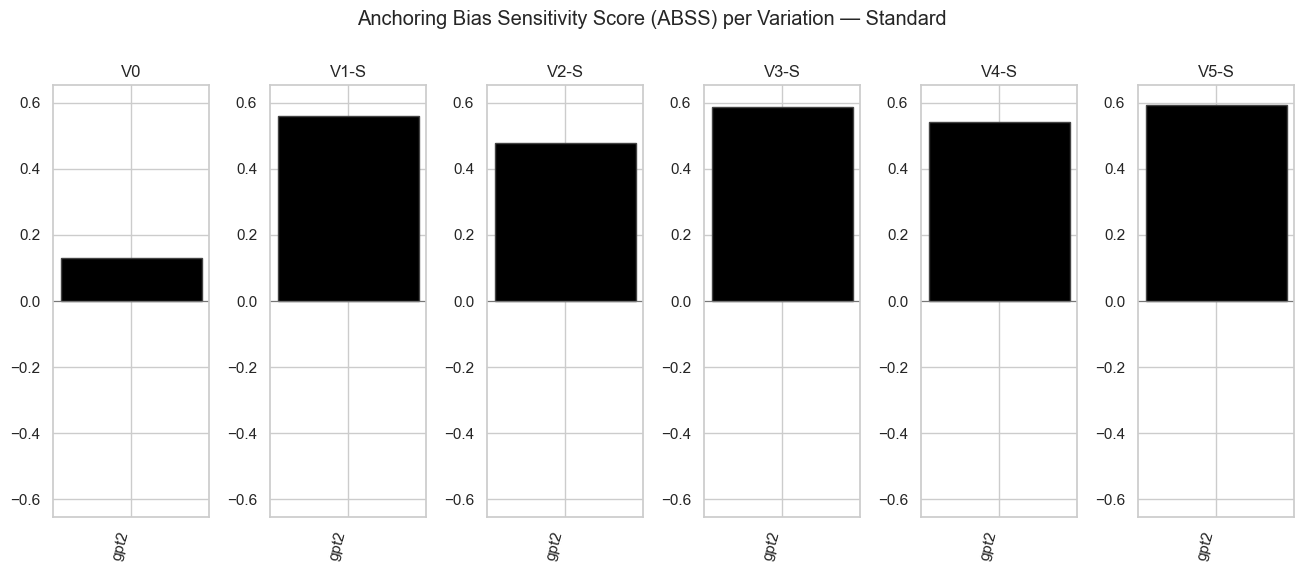

In [174]:
# Plot Standard
plot_abss_per_variation(abss_standard, title_suffix="Standard")

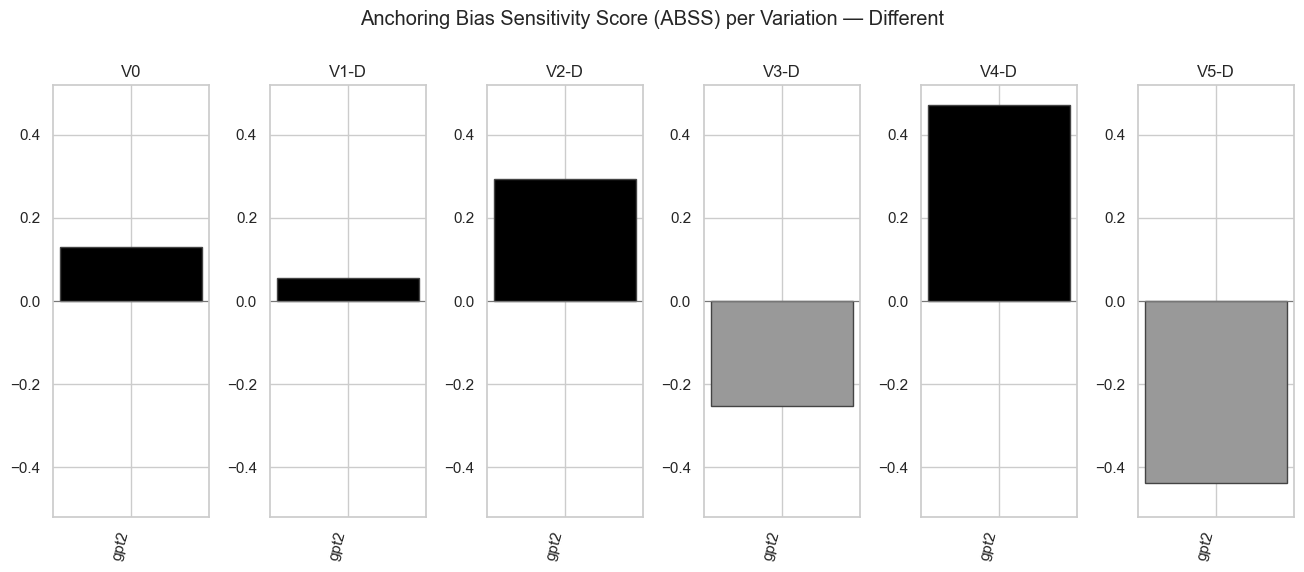

In [175]:
# Plot Different
plot_abss_per_variation(abss_different, title_suffix="Different")

## Appendix

### Toy Test Run

The following is to make sure that the results are consistent, different results often means that the template, seed, or teacher forcing is not exactly replicating the original code.

In [179]:
variations = get_prompt_variations()
v0 = variations[0]
fields = dict(v0["fields"])
fields["anchor"] = v0["anchors"][0]  # "10"

rows = []
for tok in ["0%", "1%", "2%"]:
    prompt = render_prompt(fields)
    lp  = get_sequence_logprob(model, tokenizer, prompt, tok, device=DEVICE)
    phi = estimate_shapley(model, tokenizer, fields, tok, device=DEVICE)
    rows.append({
        "VariationID": 0,
        "Anchor": "10",
        "TargetToken": tok,
        "LogProbFullPrompt": lp,
        "Shapley_scene": phi["scene"],
        "Shapley_comparative": phi["comparative"],
        "Shapley_absolute": phi["absolute"],
        "Shapley_anchor": phi["anchor"],
        "TargetInt": int(tok[:-1]),
    })

pd.DataFrame(rows)

,VariationID,Anchor,TargetToken,LogProbFullPrompt,Shapley_scene,Shapley_comparative,Shapley_absolute,Shapley_anchor,TargetInt
0,0,10,0%,-12.859124,-0.878105,-0.272223,-1.103977,-0.769104,0
1,0,10,1%,-13.529444,-0.856634,-0.007144,-1.107587,-0.725569,1
2,0,10,2%,-14.112973,-0.954145,0.123239,-1.516569,-0.699406,2


### Running time

In my local machine that has GPUs via a NVIDIA GeForce RTX had the following running time. This is just to give an idea of computational consumption.

1. GPT2:
    - Different: Processing variations: 100%|███████ 6/6 [04:00<00:00, 40.15s/it]
    - Standard: Processing variations: 100%|███████ 6/6 [04:01<00:00, 40.20s/it]
2. EleutherAI GPT Neo 125M:
    - Different: Processing variations: 100%|███████ 6/6 [04:33<00:00, 45.52s/it]
    - Standard: Processing variations: 100%|███████ 6/6 [04:26<00:00, 44.47s/it]
3. Llama 2 7B:
    - Different: Processing variations: 100%|███████ 6/6 [48:08:02<00:00, 28880.35s/it]
    - Standard: Processing variations: 100%|███████ 6/6 [62:44:15<00:00, 37642.51s/it]
4. Phi-2:
    - Different: Processing variations: 100%|███████ 6/6 [5:21:05<00:00, 3210.96s/it]
    - Standard: Processing variations: 100%|███████ 6/6 [2:50:42<00:00, 1707.03s/it]
5. Falcon RW 1B:
    - Different: Processing variations: 100%|███████ 6/6 [2:05:35<00:00, 1255.93s/it]
    - Standard: Processing variations: 100%|███████ 6/6 [2:05:44<00:00, 1257.37s/it]
6. Gemma 2B:
    - Different: Processing variations: 100%|███████ 6/6 [7:53:35<00:00, 4735.96s/it]
    - Standard: Processing variations: 100%|███████ 6/6 [7:39:43<00:00, 4597.31s/it]

### Headline Plot

C:\Users\felip\AppData\Local\Temp\ipykernel_33840\2436641428.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_right.set_xticklabels(new_labels)


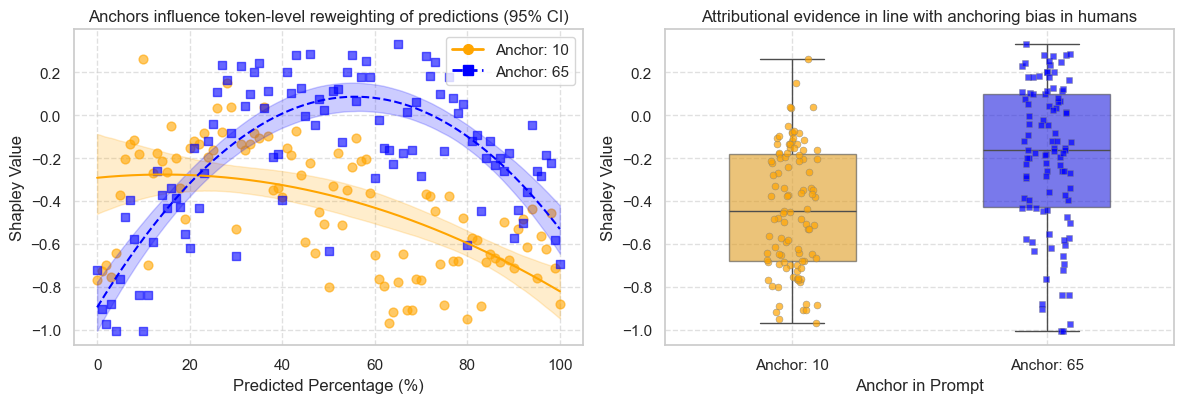

In [198]:
sns.set(style="whitegrid")

# --- helper: 2nd-order poly fit with bootstrap CI (same settings as your script) ---
def bootstrap_ci(x, y, degree=2, n_boot=5000, ci=95, rng=None):
    x = np.asarray(x); y = np.asarray(y)
    x_range = np.linspace(np.min(x), np.max(x), 200)
    if rng is None:
        rng = np.random.default_rng(42)
    preds = []
    n = len(x)
    for _ in range(n_boot):
        idx = rng.choice(n, n, replace=True)
        coeffs = np.polyfit(x[idx], y[idx], degree)
        preds.append(np.polyval(coeffs, x_range))
    preds = np.stack(preds, axis=0)
    lower = np.percentile(preds, (100 - ci) / 2, axis=0)
    upper = np.percentile(preds, 100 - (100 - ci) / 2, axis=0)
    mean  = preds.mean(axis=0)
    return x_range, mean, lower, upper

# --- main: V0-only, colored like other variations (orange/blue) ---
def plot_v0_only(df: pd.DataFrame,
                 suffix_text: str = "V0",
                 model_name: str = "gpt2",
                 save_path: str | None = None):
    """
    Plot ONLY VariationID == 0 as a two-panel figure:
      Left: Shapley vs TargetInt by anchor, with bootstrap poly trend + 95% CI
      Right: Boxplot + stripplot of Shapley by anchor
    Expects columns: VariationID, Anchor, Shapley_anchor, and TargetInt
      (or TargetToken like '42%'; will auto-parse to TargetInt).
    """
    df_plot = df.copy()

    # Ensure TargetInt exists
    if "TargetInt" not in df_plot.columns and "TargetToken" in df_plot.columns:
        df_plot["TargetInt"] = pd.to_numeric(
            df_plot["TargetToken"].str.replace("%", "", regex=False),
            errors="coerce"
        )

    # Filter to V0 only (robust if VariationID stored as str)
    v0_mask = df_plot["VariationID"].astype(int) == 0
    dvv = df_plot.loc[v0_mask].copy()
    if dvv.empty:
        raise ValueError("No rows with VariationID == 0 found.")

    # Sort anchors numerically if possible
    anchors = sorted(dvv["Anchor"].astype(str).unique(), key=lambda x: int(x))
    # Color/marker map (colored like non-base variations)
    style_map = {
        anchors[0]: {"color": "orange", "linestyle": "solid",  "marker": "o", "label": f"Anchor: {anchors[0]}"},
        anchors[1]: {"color": "blue",   "linestyle": "dashed", "marker": "s", "label": f"Anchor: {anchors[1]}"},
    } if len(anchors) >= 2 else {
        anchors[0]: {"color": "orange", "linestyle": "solid",  "marker": "o", "label": f"Anchor: {anchors[0]}"},
    }

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.2))
    ax_left, ax_right = axes

    # LEFT: scatter + bootstrap poly trend + CI
    for a in anchors:
        sub = dvv[dvv["Anchor"].astype(str) == a]
        x = sub["TargetInt"].to_numpy()
        y = sub["Shapley_anchor"].to_numpy()

        ax_left.scatter(x, y,
                        color=style_map[a]["color"],
                        marker=style_map[a]["marker"],
                        alpha=0.6, s=40)

        if len(x) >= 3:
            xr, yp, lo, hi = bootstrap_ci(x, y, degree=2, n_boot=5000, ci=95)
            ax_left.plot(xr, yp,
                         linestyle=style_map[a]["linestyle"],
                         color=style_map[a]["color"])
            ax_left.fill_between(xr, lo, hi,
                                 color=style_map[a]["color"], alpha=0.2)

    ax_left.set_title("Anchors influence token-level reweighting of predictions (95% CI)")
    ax_left.set_xlabel("Predicted Percentage (%)")
    ax_left.set_ylabel("Shapley Value")
    ax_left.grid(True, linestyle="--", alpha=0.6)

    # Build legend with both line + marker
    legend_handles = []
    for a in anchors:
        legend_handles.append(Line2D(
            [0], [0],
            color=style_map[a]["color"],
            marker=style_map[a]["marker"],
            linestyle=style_map[a]["linestyle"],
            markersize=7,
            linewidth=2,
            label=style_map[a]["label"]
        ))
    if legend_handles:
        ax_left.legend(handles=legend_handles, frameon=True)

    # RIGHT: boxplot + stripplot
    sns.boxplot(
        data=dvv, x="Anchor", y="Shapley_anchor", hue="Anchor",
        palette=[style_map[a]["color"] for a in anchors],
        showfliers=False, width=0.5, boxprops=dict(alpha=0.6),
        legend=False, ax=ax_right
    )
    for a in anchors:
        sns.stripplot(
            data=dvv[dvv["Anchor"].astype(str) == a],
            x="Anchor", y="Shapley_anchor",
            color=style_map[a]["color"], size=5,
            marker=style_map[a]["marker"], edgecolor="grey", linewidth=0.4,
            alpha=0.7, jitter=True, ax=ax_right
        )

    ax_right.set_title("Attributional evidence in line with anchoring bias in humans")
    ax_right.set_xlabel("Anchor in Prompt")
    ax_right.set_ylabel("Shapley Value")
    ax_right.grid(True, linestyle="--", alpha=0.6)

    # --- NEW: relabel x-axis ticks as "Anchor: X" ---
    current_labels = [tick.get_text() for tick in ax_right.get_xticklabels()]
    new_labels = [f"Anchor: {lbl}" for lbl in current_labels]
    ax_right.set_xticklabels(new_labels)

    # Figure title
    #fig.suptitle(f"Shapley Attribution simulation for {suffix_text} with GPT-2", y=1.02, fontsize=13)
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

    return fig, axes


# Example:
fig, axes = plot_v0_only(df_standard, suffix_text="the classic “African countries in the UN”\nanchoring experiment reported by Tversky and Kahneman (1974)", model_name="gpt2", save_path=None)
